In [1]:
import torch
import torch.nn as nn

import torch.optim as optimz
from torch.nn.modules.module import T
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.distributions.uniform import Uniform

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
text1 = 'Troll2 is great!'
text2 = 'Gymkata is great!'

corpus = list(set(text1.split(' ') + text2.split()))

In [3]:
print(corpus)

['great!', 'Gymkata', 'is', 'Troll2']


In [4]:
def oheText(text, corpus):
    text_arr = text.split(' ')
    text_len = len(text_arr)
    textOhe = [[0 for _ in range(4)] for _ in range(len(corpus))] 
    l_i = 0
    
    for i, t in enumerate(text_arr):
        word_ohe = textOhe[i]
        for j, c in enumerate(corpus):
            if c == t:
                word_ohe[j] = 1
        l_i = i
    
    st_ii = (text_len - l_i) 
    st_i = l_i + st_ii 
    
    textOhe[st_i] = textOhe[st_ii-1]
     
    return torch.Tensor(textOhe)


def targetOhe(text_ohe):
    target_ohe = [[] for _ in range(4)]
    
    for i, ohe in enumerate(text_ohe):
        j = i+1
        if j > len(text_ohe)-1:
            j = j % 3
        target_ohe[i] = text_ohe[j] 
    
    return target_ohe

In [5]:
text1_ohe = oheText(text1, corpus)
text1_ohe[3] = [1, 0, 0, 0]
label = targetOhe(text1_ohe)
text2_ohe = oheText(text2, corpus)
print(text1_ohe)
print(label)
print(text2_ohe)

TypeError: can't assign a list to a torch.FloatTensor

In [88]:
text1_ohe = torch.tensor(text1_ohe, dtype=torch.float)
text2_ohe = torch.tensor(text2_ohe, dtype=torch.float)
label_t = torch.tensor(label, dtype=torch.float)

dataLoader = DataLoader(TensorDataset(text1_ohe, label_t))

In [89]:
inputs = torch.randn((3, 4))
outputs = torch.randn((3))

In [90]:
print(inputs, outputs)

tensor([[ 1.2981, -0.6459,  0.3563,  2.5723],
        [ 1.1400,  1.1437,  0.4122, -0.1871],
        [ 1.5006,  0.9110, -0.8630, -0.1002]]) tensor([-0.5009,  0.5422,  0.7554])


In [127]:
class Embed(nn.Module):
    def __init__(self):
        super(Embed, self).__init__()
        
        min_value = -.05
        max_value = 0.5
        
        ### input weights of:
        ### top hidden layer input
        self.input1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        
        ### bottom hidden layer input
        self.input1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
       
        ### output weights : Top layer output
        self.output1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        
        ### output weights : bottom layer output
        self.output1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        
        ### softmax
        self.softmax = nn.Softmax()
        
    def forward(self, inp):
        inp = inp[0]
        
        inp_to_top_hidden = ((inp[0]*self.input1_w1)+
                             (inp[1]*self.input2_w1)+
                             (inp[2]*self.input3_w1)+
                             (inp[3]*self.input4_w1))
        
        inp_to_bottom_hidden = ((inp[0]*self.input1_w2)+
                                 (inp[1]*self.input2_w2)+
                                 (inp[2]*self.input3_w2)+
                                 (inp[3]*self.input4_w2))
        
        output1 = ((inp_to_top_hidden*self.output1_w1)+
                   (inp_to_bottom_hidden*self.output1_w2))

        output2 = ((inp_to_top_hidden*self.output2_w1)+
                   (inp_to_bottom_hidden*self.output2_w2))

        output3 = ((inp_to_top_hidden*self.output3_w1)+
                   (inp_to_bottom_hidden*self.output3_w2))

        output4 = ((inp_to_top_hidden*self.output4_w1)+
                   (inp_to_bottom_hidden*self.output4_w2))
        
        output_preSoftMax = torch.stack([output1, output2, output3, output4])
        
        
        return output_preSoftMax
    


In [128]:
import re

embed = Embed().to('cuda')
loss_fn = nn.CrossEntropyLoss()
optim = optimz.Adam(embed.parameters(), lr=0.01)

### w1 = top activation, w2 = bottom activation
data = {
    'w1': [],
    'w2': [],
    'word': corpus,
    'input': []
}

In [129]:
i = 1
for name, param in embed.named_parameters():
    if i <= 4:
        data['input'].append('input' + str(i))
        i += 1 
    if re.match(r'.*(output).*', name):
        continue
    
    if re.match(r'^(input).*(w1)', name):
        data['w1'].append(param.data.item())
    else:
        data['w2'].append(param.data.item())

<Axes: xlabel='w1', ylabel='w2'>

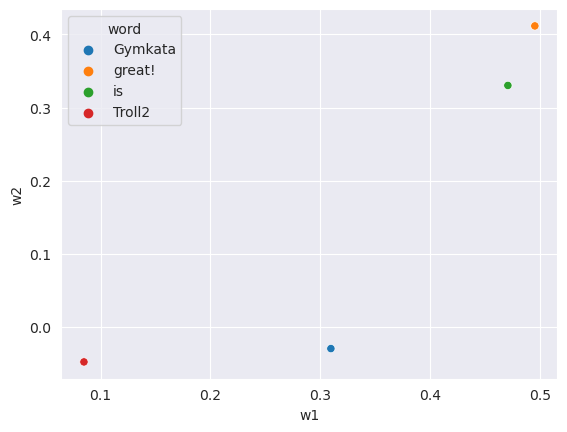

In [130]:
df = pd.DataFrame(data)
sns.scatterplot(data=df, x=df['w1'], y=df['w2'], hue='word')

In [131]:
print(next(iter(dataLoader)))

[tensor([[0., 0., 0., 1.]]), tensor([[0., 0., 1., 0.]])]


In [132]:
epochs = 100

size = len(dataLoader.dataset)
embed.train()
for epoch in range(epochs):
    for i, batch in enumerate(dataLoader):
        optim.zero_grad()
        input_i, label_i = batch
        input_i, label_i = input_i.to('cuda'), label_i.to('cuda')
        
        out_i = embed(input_i)
        loss = loss_fn(out_i, label_i[0])
        
        loss.backward()
        optim.step()

        loss, current = loss.item(), i
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


loss: 1.390894  [    0/    4]
loss: 1.322371  [    1/    4]
loss: 1.362848  [    2/    4]
loss: 1.420796  [    3/    4]
loss: 1.379899  [    0/    4]
loss: 1.300694  [    1/    4]
loss: 1.345172  [    2/    4]
loss: 1.411333  [    3/    4]
loss: 1.370380  [    0/    4]
loss: 1.283361  [    1/    4]
loss: 1.327948  [    2/    4]
loss: 1.400724  [    3/    4]
loss: 1.360076  [    0/    4]
loss: 1.265833  [    1/    4]
loss: 1.310890  [    2/    4]
loss: 1.389179  [    3/    4]
loss: 1.348691  [    0/    4]
loss: 1.247326  [    1/    4]
loss: 1.293803  [    2/    4]
loss: 1.376648  [    3/    4]
loss: 1.335984  [    0/    4]
loss: 1.227582  [    1/    4]
loss: 1.276308  [    2/    4]
loss: 1.362984  [    3/    4]
loss: 1.321722  [    0/    4]
loss: 1.206521  [    1/    4]
loss: 1.257966  [    2/    4]
loss: 1.347995  [    3/    4]
loss: 1.305682  [    0/    4]
loss: 1.184159  [    1/    4]
loss: 1.238485  [    2/    4]
loss: 1.331470  [    3/    4]
loss: 1.287657  [    0/    4]
loss: 1.16

<Axes: xlabel='w1', ylabel='w2'>

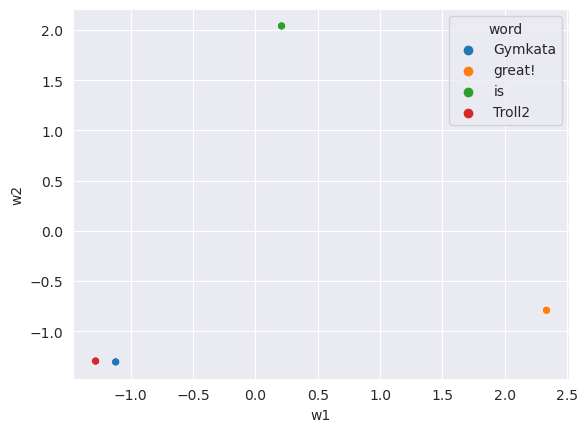

In [133]:
i = 1
data = {
    'w1': [],
    'w2': [],
    'word': corpus,
    'input': []
}
for name, param in embed.named_parameters():
    if i <= 4:
        data['input'].append('input' + str(i))
        i += 1
    if re.match(r'.*(output).*', name):
        continue

    if re.match(r'^(input).*(w1)', name):
        data['w1'].append(param.data.item())
    else:
        data['w2'].append(param.data.item())
df = pd.DataFrame(data)
sns.scatterplot(data=df, x=df['w1'], y=df['w2'], hue='word')

In [201]:
corpus_map = {i:t for i, t in enumerate(corpus)}

In [202]:
print(corpus_map)

{0: 'Gymkata', 1: 'great!', 2: 'is', 3: 'Troll2'}


In [211]:
def predict(text):
    softmax = nn.Softmax()
    text_ohe = oheText(text, corpus)
    loader = DataLoader(text_ohe, batch_size=1, shuffle=False)
    embed.eval()
    print(text_ohe)
    pred_text = ''
    with torch.no_grad():
        for i , batch in enumerate(loader):
            tensr = batch.to('cuda')
            #pred = embed(torch.tensor([[1, 0, 0, 0]]))
            pred = embed(tensr)
            print(softmax(pred))
            pred_text += corpus_map[pred.argmax(0).item()] + ' '
    
    print(pred_text)
        

In [212]:
predict(text2)

tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.]])
tensor([2.4029e-03, 6.4391e-04, 9.8232e-01, 1.4633e-02], device='cuda:0')
tensor([2.4852e-02, 9.4873e-01, 1.8694e-04, 2.6233e-02], device='cuda:0')
tensor([0.9645, 0.0196, 0.0055, 0.0104], device='cuda:0')
tensor([2.4029e-03, 6.4391e-04, 9.8232e-01, 1.4633e-02], device='cuda:0')
is great! Gymkata is 


In [176]:
print(text2)
print(corpus)

Gymkata is great!
['Gymkata', 'great!', 'is', 'Troll2']
